In [16]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [17]:
# Set random seed for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

Random Seed:  8784


In [18]:
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [19]:
# dataset路径
dataroot="/home/msy/jupyterProjects/data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
# size using a transformer
image_size=64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent潜在 vector (i.e. size of generator input)
nz = 100

#size of feature map in generator
ngf=64

#size of feature maps in discriminator
ndf=64

#Number of training epochs
num_epochs=5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

#Number of GPUs available. Use 0 for CPU mode
ngpu=1

In [20]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [21]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

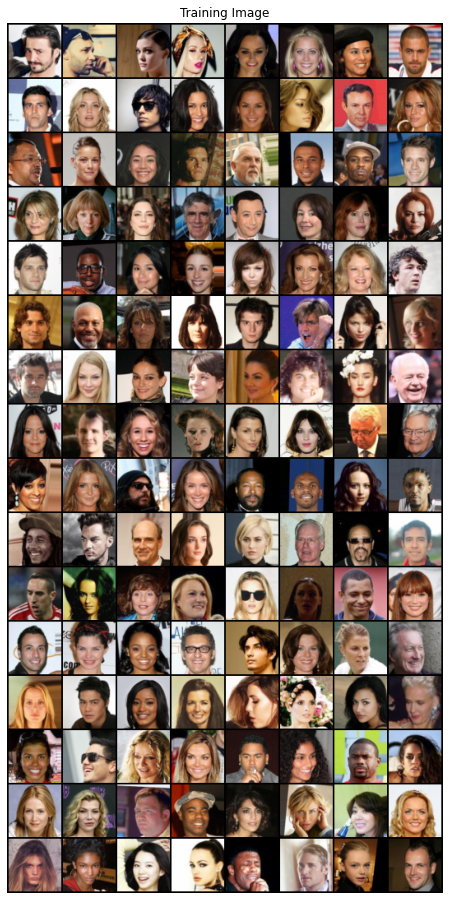

In [22]:
# Plot some training images
real_batch=next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Image")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device),
                                        padding=2,normalize=True).cpu(),(1,2,0)))

In [23]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname=m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

In [24]:
real_batch[0].size()

torch.Size([128, 3, 64, 64])

In [25]:
#Generator
class Generator(nn.Module):
    def __init__(self,ngpu):
        super(Generator,self).__init__()
        self.ngpu=ngpu
        self.main=nn.Sequential(
            #在生成图像中，我们需要不断的扩大图像的尺寸，逆卷积ConvTranspose2d
            #in_channels,out_channels,kernel,stride,padding
            #nz=100,ngf=64
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            #进行数据的归一化处理，这使得数据在进行Relu之前不会因为数据过大而导致网络性能的不稳定
            # num_features：一般输入参数为batch_size*num_features*height*width，即为其中特征的数量
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            #双曲正切激活函数
            nn.Tanh()
            # state size. (nc) x 64 x 64 至此生成64*64图像
        )
    def forward(self, input):
        return self.main(input)

In [26]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [27]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64 ndf=64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), #(64+1*2-4)/2+1=32
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [28]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [36]:
#Binary Cross Entropy loss (BCELoss) function
#ℓ(x,y)=L={l1,…,lN}⊤,ln=−[yn⋅logxn+(1−yn)⋅log(1−xn)]
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [37]:
#Training
#Part 1 - Train the Discriminator
'''
need to maximize log(D(x))+log(1−D(G(z)))

First, we will construct整理 a batch of real samples from the training set,
forward pass through D, calculate the loss (log(D(x)))
then calculate the gradients in a backward pass

Secondly, we will construct构造 a batch of fake samples with the current generator, 
forward pass this batch through D, calculate the loss (log(1−D(G(z))))
accumulate the gradients with a backward pass
'''
#Part
#2 - Train the Generator
'''
need to minimizing log(1−D(G(z))),但log(1−D(G(z)))梯度不大
therefore， maximize  log(D(G(z))

classifying the Generator output from Part 1 with the Discriminator
computing G’s loss using real labels as GT（使用实数标签 GT） 
computing G’s gradients in a backward pass,
finally updating G’s parameters with an optimizer step. 
'''

#Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

In [38]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    #for each batch in the dataloader
    for i ,data in enumerate(dataloader,0):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with all-real batch
        netD.zero_grad()
        
        #Format batch
        real_cpu=data[0].to(device)
        
        b_size=real_cpu.size(0)
        
        label=torch.full((b_size,),real_label,device=device)
        #Forward pass real batch through D
        output=netD(real_cpu).view(-1)
        #Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake=netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake=criterion(output,label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1=output.mean().item()
        #Add the gradients from the all-real and all-fake batches
        errD=errD_real+errD_fake
        #Update D
        optimizerD.step()
        
        #(2)Update G network :maxmize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator cost
        #Since we just update D,perform another forward pass of all-fale batch through D
        output=netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        #Calculate gradients for G
        errG.backward()
        D_G_z2=output.mean().item()
        #Update G
        optimizerG.step()
        
        #Output training stats
        if i%50==0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        #save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if(iters%500==0) or ((epoch==num_epochs-1)and(i==len(dataloader)-1)):
            with torch.no_grad():
                fake=netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake))
        iters=+1

Starting Training Loop...
[0/5][0/1586]	Loss_D: 0.5154	Loss_G: 9.1359	D(x): 0.9835	D(G(z)): 0.3317 / 0.0002
[0/5][50/1586]	Loss_D: 2.4683	Loss_G: 28.6239	D(x): 0.9638	D(G(z)): 0.8566 / 0.0000
[0/5][100/1586]	Loss_D: 0.2890	Loss_G: 6.9732	D(x): 0.8982	D(G(z)): 0.0952 / 0.0085
[0/5][150/1586]	Loss_D: 0.2924	Loss_G: 5.0145	D(x): 0.9064	D(G(z)): 0.1346 / 0.0146
[0/5][200/1586]	Loss_D: 0.8739	Loss_G: 1.7866	D(x): 0.5670	D(G(z)): 0.0744 / 0.2127
[0/5][250/1586]	Loss_D: 0.3238	Loss_G: 5.1017	D(x): 0.8174	D(G(z)): 0.0397 / 0.0092
[0/5][300/1586]	Loss_D: 0.6019	Loss_G: 2.4681	D(x): 0.6994	D(G(z)): 0.0944 / 0.1186
[0/5][350/1586]	Loss_D: 0.9450	Loss_G: 6.6143	D(x): 0.7589	D(G(z)): 0.3990 / 0.0054
[0/5][400/1586]	Loss_D: 0.5514	Loss_G: 5.6575	D(x): 0.9040	D(G(z)): 0.3214 / 0.0098
[0/5][450/1586]	Loss_D: 0.6751	Loss_G: 6.6208	D(x): 0.8461	D(G(z)): 0.3313 / 0.0033
[0/5][500/1586]	Loss_D: 0.2759	Loss_G: 1.9067	D(x): 0.9005	D(G(z)): 0.1322 / 0.2217
[0/5][550/1586]	Loss_D: 0.3854	Loss_G: 5.5014	D(x): 

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig=plt.figure(figsize=(8,8))
plt.axis("off")
ims=[[plt.imshow(np.transpose(i,(1,2,0)),animated=True)] for i in img_list]
ani=animation.ArtistAnimation(fig,ims,interval=1000,repeat_delay=1000,blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

#plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Image")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device[:64],padding=5,normalize=True).cpu(),(1,2,0))))

#plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()